<a href="https://colab.research.google.com/github/epage480/tutorial_playground/blob/main/Tutorial_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/epage480/tutorial_playground/

fatal: destination path 'tutorial_playground' already exists and is not an empty directory.


In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm
sns.set()

<ipython-input-2-a5b8b102341c>:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
class SimpleClassifier(nn.Module):
  def __init__(self, num_inputs, num_hidden, num_outputs):
    super().__init__()
    # Initialize the modules we need to build the network
    self.linear1 = nn.Linear(num_inputs, num_hidden)
    self.act_fn = nn.Tanh()
    self.linear2 = nn.Linear(num_hidden, num_outputs)

  def forward(self, x):
    # Perform the calculation of the model to determine the prediction
    x = self.linear1(x)
    x = self.act_fn(x)
    x = self.linear2(x)
    return x

In [4]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [5]:
class XORDataset(data.Dataset):
  def __init__(self, size, std=0.1):
    """
    Inputs:
        size - Number of data points we want to generate
        std - Standard deviation of the noise (see generate_continuous_xor function)
    """
    super().__init__()
    self.size = size
    self.std = std
    self.generate_continuous_xor()

  def generate_continuous_xor(self):
    data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
    label = (data.sum(dim=1) == 1).to(torch.long)
    data += self.std * torch.randn(data.shape)

    self.data = data
    self.label = label

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [6]:
dataset = XORDataset(size=200)
print("size of dataset:", len(dataset))

size of dataset: 200


In [7]:
def visualize_samples(data, label):
  if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
  if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  plt.figure(figsize=(4,4))
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 0")
  plt.title("Dataset samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend()

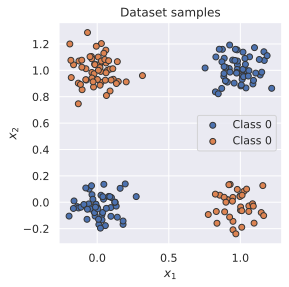

In [8]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [9]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [10]:
data_inputs, data_labels = next(iter(data_loader))

print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[-0.0381,  1.0878],
        [-0.0178,  1.0473],
        [ 1.0319,  1.0902],
        [ 0.0328, -0.0958],
        [-0.0289,  0.9130],
        [ 0.9445,  0.0083],
        [ 0.0083,  1.0005],
        [ 0.8745,  1.1592]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 0, 1, 1, 1, 0])


In [11]:
loss_fn = nn.BCEWithLogitsLoss()

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [13]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model.to(device)

cuda


SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
def train_model(model, optimizer, data_loader, loss_fn, num_epochs=100):
  model.train()

  for epoch in tqdm(range(num_epochs)):
    for data, labels in data_loader:
      data   = data.to(device)
      labels = labels.to(device)

      preds = model(data)
      preds = preds.squeeze(dim=1) # outputs is [batchsize, 1] but we want [batch size]

      loss = loss_fn(preds, labels.float())

      # Gradients are not overwritten, just added to existing ones so must be 0'd
      optimizer.zero_grad()
      # backpropogation
      loss.backward()

      optimizer.step()

In [24]:
train_model(model,optimizer, data_loader, loss_fn, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 3.1327,  3.0863],
        [ 3.3168, -1.6563],
        [ 1.9471, -3.2157],
        [-0.9892, -1.1601]], device='cuda:0')), ('linear1.bias', tensor([-0.8548,  0.1762, -0.5796, -0.5797], device='cuda:0')), ('linear2.weight', tensor([[ 4.2449, -4.5159,  4.3102, -0.7230]], device='cuda:0')), ('linear2.bias', tensor([-0.3198], device='cuda:0'))])


In [26]:
torch.save(state_dict, "our_model.tar")

In [27]:
# Load state dict from the disk
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify the parameters are the same
print("Original:", model.state_dict())
print("loaded:  ", new_model.state_dict())
# assert model.state_dict() == new_model.state_dict()

Original: OrderedDict([('linear1.weight', tensor([[ 3.1327,  3.0863],
        [ 3.3168, -1.6563],
        [ 1.9471, -3.2157],
        [-0.9892, -1.1601]], device='cuda:0')), ('linear1.bias', tensor([-0.8548,  0.1762, -0.5796, -0.5797], device='cuda:0')), ('linear2.weight', tensor([[ 4.2449, -4.5159,  4.3102, -0.7230]], device='cuda:0')), ('linear2.bias', tensor([-0.3198], device='cuda:0'))])
loaded:   OrderedDict([('linear1.weight', tensor([[ 3.1327,  3.0863],
        [ 3.3168, -1.6563],
        [ 1.9471, -3.2157],
        [-0.9892, -1.1601]])), ('linear1.bias', tensor([-0.8548,  0.1762, -0.5796, -0.5797])), ('linear2.weight', tensor([[ 4.2449, -4.5159,  4.3102, -0.7230]])), ('linear2.bias', tensor([-0.3198]))])


In [28]:
test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)


In [29]:
def eval_model(model, data_loader):
  model.eval()
  true_preds, num_preds = 0., 0.

  with torch.no_grad():
    for data, labels in data_loader:
      data, labels = data.to(device), labels.to(device)
      preds = model(data)
      preds = preds.squeeze(dim=1)
      preds = torch.sigmoid(preds)
      pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 & 1

      true_preds += (pred_labels == labels).sum()
      num_preds += labels.shape[0]

  acc = true_preds / num_preds
  print(f"Accuracy of the model: {100*acc:4.2f}%")

In [30]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


In [22]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad():.." over the whole function
def visualize_classification(model, data, label):


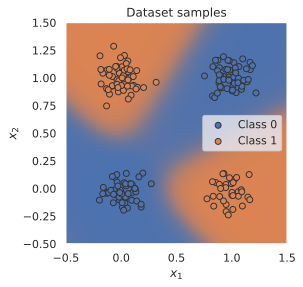

In [32]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig
_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

In [33]:
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard